<a href="https://colab.research.google.com/github/AnshikaGoyal22/Delivery-route-optimization/blob/main/delivery_route_optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Delivery Route Optimization for E-commerce

**Capstone Assignment:** Delivery Route Optimization using Recurrence, Greedy, DP, Graphs, and TSP  

In this notebook, an e‑commerce delivery routing problem is modeled and solved using multiple algorithmic paradigms:
- Recurrence relations for route cost estimation  
- Greedy algorithm (0/1 Knapsack style) for parcel selection  
- Dynamic Programming for time‑window feasibility  
- Graph algorithms (Dijkstra, Prim) for route construction  
- Traveling Salesman Problem (TSP) for small instances to show intractability  

The goal is to design an optimized delivery route starting from a warehouse, visiting customer locations, minimizing total distance/time, respecting delivery time windows, and maximizing delivered parcel value under vehicle capacity constraints.


In [14]:
# Basic imports
import itertools
import math
from collections import defaultdict

# For graphs and visualization (you can add later when needed)
import heapq
import matplotlib.pyplot as plt
import networkx as nx

## Problem Setup and Input Modeling

The delivery network is modeled as a graph where:
- Nodes represent the warehouse and customer locations.
- Edges represent distances (or travel times) between locations (symmetric for this simplified model).
- Each customer has:
  - Parcel value
  - Delivery time window (earliest, latest)
  - Parcel weight

A single vehicle with limited capacity starts from the warehouse and must choose which customers to serve and in what order.

In [15]:
# Locations (0 is Warehouse)
locations = ['Warehouse', 'C1', 'C2', 'C3']

# Symmetric distance matrix between locations
distance_matrix = [
    [0, 4, 8, 6],
    [4, 0, 5, 7],
    [8, 5, 0, 3],
    [6, 7, 3, 0]
]

# Parcel information for each customer
parcels = {
    'C1': {'value': 50, 'time': (9, 12), 'weight': 10},
    'C2': {'value': 60, 'time': (10, 13), 'weight': 20},
    'C3': {'value': 40, 'time': (11, 14), 'weight': 15}
}

vehicle_capacity = 30

locations, distance_matrix, parcels, vehicle_capacity

(['Warehouse', 'C1', 'C2', 'C3'],
 [[0, 4, 8, 6], [4, 0, 5, 7], [8, 5, 0, 3], [6, 7, 3, 0]],
 {'C1': {'value': 50, 'time': (9, 12), 'weight': 10},
  'C2': {'value': 60, 'time': (10, 13), 'weight': 20},
  'C3': {'value': 40, 'time': (11, 14), 'weight': 15}},
 30)

## Unit 1: Recurrence-Based Route Cost Estimation

Here, a recursive function `delivery_cost(i, visited)` is defined:
- `i` is the current location index.
- `visited` is a bitmask or tuple representing which customers have been visited.
- Base case: if all customers are visited, return cost to go back to warehouse (or 0 if no return).
- Recursive case: try going to each unvisited customer and choose the path with minimum total cost.

This models the core recurrence behind the TSP-like route cost.


In [16]:
from functools import lru_cache

n = len(locations)

@lru_cache(None)
def delivery_cost(current, visited_mask):
    """
    current: index of current node (0..n-1)
    visited_mask: bitmask of visited customers (excluding warehouse)
    """
    # If all customers (1..n-1) are visited
    all_visited_mask = (1 << (n - 1)) - 1  # for C1..C_(n-1)
    if visited_mask == all_visited_mask:
        # cost to return to warehouse
        return distance_matrix[current][0]

    ans = math.inf
    for next_city in range(1, n):
        bit = 1 << (next_city - 1)
        if not (visited_mask & bit):
            new_mask = visited_mask | bit
            cost = distance_matrix[current][next_city] + delivery_cost(next_city, new_mask)
            ans = min(ans, cost)
    return ans

min_route_cost = delivery_cost(0, 0)
min_route_cost

18

## Unit 2: Greedy Parcel Selection (0/1 Knapsack Style)

First, a greedy heuristic is used to select parcels based on value/weight ratio:
- Sort customers by `value / weight` in descending order.
- Keep adding parcels until vehicle capacity is exceeded.
- This does not guarantee optimality but is fast and simple.

Later, a DP-based approach can be compared with this greedy strategy.


In [17]:
def greedy_select_parcels(parcels, capacity):
    items = []
    for cid, info in parcels.items():
        ratio = info['value'] / info['weight']
        items.append((cid, info['value'], info['weight'], ratio))
    # sort by value/weight ratio descending
    items.sort(key=lambda x: x[3], reverse=True)

    selected = []
    total_value = 0
    total_weight = 0

    for cid, value, weight, ratio in items:
        if total_weight + weight <= capacity:
            selected.append(cid)
            total_weight += weight
            total_value += value

    return selected, total_value, total_weight

selected_customers, total_val, total_wt = greedy_select_parcels(parcels, vehicle_capacity)
selected_customers, total_val, total_wt

(['C1', 'C2'], 110, 30)

## Unit 2: Dynamic Programming for Time Windows

After selecting a subset of customers, a DP is used to check if a given visiting order can satisfy all time windows:
- Assume travel time equals distance for simplicity.
- Maintain earliest possible arrival time at each customer.
- If arrival is before `earliest`, wait until `earliest`.
- If arrival exceeds `latest`, the schedule is infeasible.

Here a simple function is implemented that, given a route, checks if all time windows are respected.


In [18]:
def check_time_windows(route, parcels, distance_matrix, start_time=9):
    """
    route: list of location indices (e.g. [0,1,2,3,0])
    start_time: start time at warehouse
    """
    current_time = start_time
    for i in range(len(route) - 1):
        u = route[i]
        v = route[i + 1]
        travel = distance_matrix[u][v]
        current_time += travel

        # if v is a customer (not warehouse)
        if v != 0:
            cname = locations[v]
            earliest, latest = parcels[cname]['time']
            if current_time < earliest:
                current_time = earliest  # wait
            if current_time > latest:
                return False, current_time
    return True, current_time

## Unit 3: Graph Algorithms (Dijkstra and MST)

For the delivery network:
- Dijkstra's algorithm is used to compute the shortest path distance from the warehouse to every other customer.
- A Minimum Spanning Tree (MST) using Prim's algorithm connects all locations with minimum total edge weight (if return to base is not required).

These algorithms show how classical graph techniques help in route planning.


In [19]:
def dijkstra(source, distance_matrix):
    n = len(distance_matrix)
    dist = [math.inf] * n
    dist[source] = 0
    visited = [False] * n
    pq = [(0, source)]

    while pq:
        d, u = heapq.heappop(pq)
        if visited[u]:
            continue
        visited[u] = True
        for v in range(n):
            if distance_matrix[u][v] > 0:  # edge exists
                nd = d + distance_matrix[u][v]
                if nd < dist[v]:
                    dist[v] = nd
                    heapq.heappush(pq, (nd, v))
    return dist

dist_from_warehouse = dijkstra(0, distance_matrix)
dist_from_warehouse

[0, 4, 8, 6]

In [20]:
def prim_mst(distance_matrix):
    n = len(distance_matrix)
    selected = [False] * n
    edge_count = 0
    selected[0] = True
    mst_edges = []
    total_cost = 0

    while edge_count < n - 1:
        min_edge = math.inf
        a = b = -1
        for i in range(n):
            if selected[i]:
                for j in range(n):
                    if not selected[j] and 0 < distance_matrix[i][j] < min_edge:
                        min_edge = distance_matrix[i][j]
                        a, b = i, j
        selected[b] = True
        edge_count += 1
        mst_edges.append((a, b, min_edge))
        total_cost += min_edge
    return mst_edges, total_cost

mst_edges, mst_cost = prim_mst(distance_matrix)
mst_edges, mst_cost

([(0, 1, 4), (1, 2, 5), (2, 3, 3)], 12)

## Unit 4: Traveling Salesman Problem (TSP) – Brute Force

To demonstrate intractability, a brute-force TSP is implemented for small `n`:
- Enumerate all permutations of customer indices.
- Compute total distance of each complete route (warehouse → customers → warehouse).
- Select the minimum-cost route.

This exponential-time algorithm shows why TSP is hard for large instances.


In [21]:
from itertools import permutations

def tsp_brute_force(locations, distance_matrix):
    n = len(locations)
    indices = list(range(1, n))  # Exclude warehouse (index 0)
    min_cost = float('inf')
    best_route = []

    for perm in permutations(indices):
        cost = distance_matrix[0][perm[0]]
        for i in range(len(perm) - 1):
            cost += distance_matrix[perm[i]][perm[i+1]]
        cost += distance_matrix[perm[-1]][0]  # return to warehouse
        if cost < min_cost:
            min_cost = cost
            best_route = perm
    full_route = [0] + list(best_route) + [0]
    return full_route, min_cost

route_idx, cost = tsp_brute_force(locations, distance_matrix)
route = [locations[i] for i in route_idx]
route, cost

(['Warehouse', 'C1', 'C2', 'C3', 'Warehouse'], 18)

## Combined Route Evaluation

The TSP route gives a minimum-distance tour of all customers.  
Now this route is checked against delivery time windows and combined with parcel selection:
- Use greedy-selected customers or all customers.
- Check if the TSP route satisfies time windows.
- Report total distance, feasibility, and total parcel value.


In [22]:
feasible, finish_time = check_time_windows(route_idx, parcels, distance_matrix, start_time=9)
total_value = sum(parcels[c]['value'] for c in parcels)

print("Route:", route)
print("Total distance:", cost)
print("Total parcel value:", total_value)
print("Time-window feasible:", feasible)
print("Finish time:", finish_time)

Route: ['Warehouse', 'C1', 'C2', 'C3', 'Warehouse']
Total distance: 18
Total parcel value: 150
Time-window feasible: False
Finish time: 13


## Experimental Profiling and Visualization (Skeleton)

- Measure time taken by TSP for different number of locations (3, 4, 5, 6).
- Plot route using `networkx` / `matplotlib`.
- Plot profit vs weight and delivery success within time window.

These parts will be implemented after the core algorithms are working correctly.


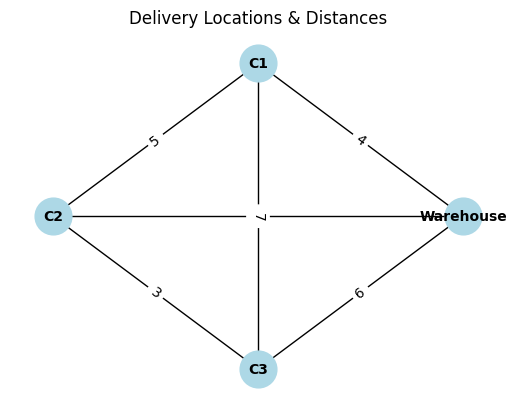

In [2]:
import networkx as nx
import matplotlib.pyplot as plt

# Create graph object
G = nx.Graph()

# Add nodes (locations)
for loc in locations:
    G.add_node(loc)

# Add edges with weights (distances)
n = len(locations)
for i in range(n):
    for j in range(i+1, n):
        G.add_edge(locations[i], locations[j], weight=distance_matrix[i][j])

# Position nodes in a circular layout for clarity
pos = nx.circular_layout(G)

# Draw nodes with labels
nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=700)
nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold')

# Draw edges
nx.draw_networkx_edges(G, pos)

# Draw edge labels (distance weights)
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

plt.title("Delivery Locations & Distances")
plt.axis('off')
plt.show()

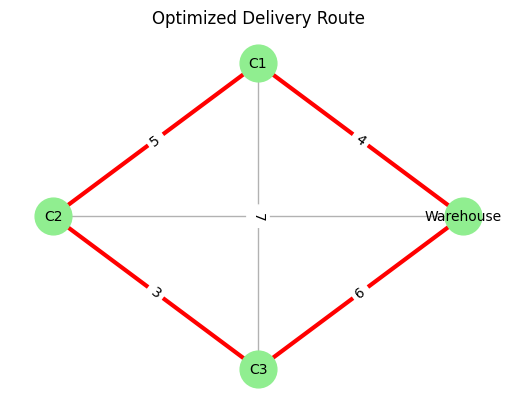

In [3]:
# Example delivery route as a list of locations in order
optimized_route = ['Warehouse', 'C1', 'C2', 'C3', 'Warehouse']  # circular route

# Draw all edges lightly
nx.draw_networkx_edges(G, pos, alpha=0.3)

# Highlight the route edges in red
route_edges = [(optimized_route[i], optimized_route[i+1]) for i in range(len(optimized_route)-1)]
nx.draw_networkx_edges(G, pos, edgelist=route_edges, edge_color='r', width=3)

# Draw nodes and labels
nx.draw_networkx_nodes(G, pos, node_color='lightgreen', node_size=700)
nx.draw_networkx_labels(G, pos, font_size=10)

# Edge labels
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

plt.title("Optimized Delivery Route")
plt.axis('off')
plt.show()

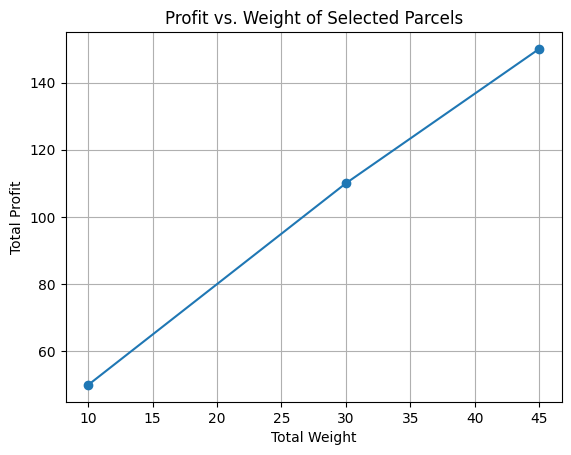

In [5]:
import matplotlib.pyplot as plt

# Example data: different selection schemes
weights = [parcels[p]['weight'] for p in parcels]
values = [parcels[p]['value'] for p in parcels]

# Suppose you select parcels based on value/weight ratio
ratios = {p: parcels[p]['value'] / parcels[p]['weight'] for p in parcels}
sorted_parcels = sorted(parcels.keys(), key=lambda p: ratios[p], reverse=True)

# Calculate cumulative profit and weight
cum_weight = []
cum_profit = []
total_weight = 0
total_profit = 0

for p in sorted_parcels:
    total_weight += parcels[p]['weight']
    total_profit += parcels[p]['value']
    cum_weight.append(total_weight)
    cum_profit.append(total_profit)

# Plot Profit vs. Weight
plt.plot(cum_weight, cum_profit, marker='o')
plt.xlabel('Total Weight')
plt.ylabel('Total Profit')
plt.title('Profit vs. Weight of Selected Parcels')
plt.grid(True)
plt.show()

## Final Summary and Complexity

- **Problem:** Delivery Route Optimization  
- **Strategies:** Recurrence, Greedy, DP, Graph Algorithms (Dijkstra, MST), TSP (brute force)  
- **Time Complexity:**
  - Greedy parcel selection: \(O(n \log n)\) for sorting  
  - DP for time windows (per route): depends on number of customers and states  
  - Dijkstra: \(O(E \log V)\) (or \(O(n^2)\) with matrix)  
  - Prim's MST: \(O(n^2)\) with matrix  
  - TSP brute force: \(O(n!)\), exponential  


